Read LAS and DLIS files from Equinor Volve Data

In [1]:
import numpy as np
import lasio
import dlisio
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
%matplotlib inline  
# Ensure that we can see pandas tables of up to 100 rows
pd.set_option('display.max_rows', 100)
# suppress the chained indexing warnings entirely
pd.set_option('mode.chained_assignment',None)

# Set a default DPI for all figures in this file. Lower DPI gives smaller figures, higher bigger.
mpl.rcParams['figure.dpi'] = 150

In [2]:
#Function to merge well log files from Volve data and create well_name column

def merge_createname(data1, data2=None, Well=None, **kwargs):
    #merge two dataframes based on column 'DEPTH'
    if data2 is not None:
        dt=pd.merge_asof(data1, data2, on='DEPTH', allow_exact_matches=True)
    else:
        dt=data1
    
    #create column for well name
    for label, value in kwargs.items():
        dt['WELL_NAME'] = Series(np.repeat(value,len(dt['DEPTH'])))
    cols = dt.columns.tolist()  #rearrange column for well name first
    cols = cols[-1:] + cols[:-1]
    dt = dt[cols]
    
    #check if Depth data matches intervals set by STRT, STOP and STEP values 
    if Well is not None:
        d1=np.array(Well['DEPTH'])
        if Well.well['STEP'].value==0:
            Well.well['STEP'].value=dt['DEPTH'].diff()[1]
            d2=np.arange(Well.well['STRT'].value,Well.well['STOP'].value,Well.well['STEP'].value)
        else:
            d2=np.arange(Well.well['STRT'].value,Well.well['STOP'].value+Well.well['STEP'].value,Well.well['STEP'].value)
        if np.abs(d1-d2).sum()>1e-3:
            Well.curves['DEPTH'].data=d2
            dt['DEPTH']=d2
            
    #Drop non-essential columns
    unwanted = {'ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BVW', 'DRHO', 'NBGRCFM', 'DELTA',
                'GRMAX','GRMIN', 'J', 'BADDATA_FLAG', 'KLHC_INT', 'M', 'N', 'PERF_FLAG', 'PORD',
                'RHOFL', 'RHOMA', 'RW', 'SWIRR', 'RD', 'RM', 'RT', 'ROP5_RM', 'RS',
                'PHID', 'ROBB', 'ROBU', 'DRHB', 'DRHU', 'TEMP'
                }
    for column in dt.columns:
        if column in unwanted:
            dt.drop(column, axis=1, inplace=True)
            
    # replacing all infinity values with NAN
    dt.replace([np.inf, -np.inf], np.nan, inplace = True)

    return dt

In [3]:
#%%Loading LAS Dataset

fname = 'LAS_FILES/15_9-19_A_CPI.las'
Well_F19A = lasio.read(fname)
dataF19A=DataFrame(Well_F19A.data, columns=list(Well_F19A.curvesdict.keys()))
#calculate GR from VSH formula
dataF19A['GR'] = dataF19A['GRMAX'] - dataF19A['VSH']*(dataF19A['GRMAX']-dataF19A['GRMIN'])
#calculate RHOB from Density porosity formula
dataF19A['RHOB'] = dataF19A['RHOMA'] - dataF19A['PORD']*(dataF19A['RHOMA']-dataF19A['RHOFL'])
#calculate NPHI from  porosity formula
dataF19A['NPHI'] = dataF19A['PORD'] + (dataF19A['PHIF']-dataF19A['PORD']-0.01)/0.4
dataF19A['NPHI'] = dataF19A['NPHI'].abs()   
#calculate RT from  SW formula
dataF19A['RPCEHM'] = dataF19A['RW']/(dataF19A['SW']**(-1/dataF19A['N']) * (dataF19A['PHIF']+0.01)**(dataF19A['M']))
dataF19A = merge_createname(dataF19A, None, Well_F19A, name='Well_F19A')
del Well_F19A
#Keep any rows with 6 and more non-nan values
dataF19A.dropna(thresh=6,inplace=True)

fname = 'LAS_FILES/15_9-19_BT2_CPI.las'
Well_F19BT2 = lasio.read(fname)
dataF19BT2=DataFrame(Well_F19BT2.data, columns=list(Well_F19BT2.curvesdict.keys()))
#calculate RT from  SW formula
dataF19BT2['RPCEHM'] = dataF19BT2['RW']/(dataF19BT2['SW']**(-1/2.45) * dataF19BT2['PHIF']**1.79)
dataF19BT2 = merge_createname(dataF19BT2, None, Well_F19BT2, name='Well_F19BT2')
del Well_F19BT2
#Keep any rows with 5 and more non-nan values
dataF19BT2.dropna(thresh=5,inplace=True)

fname = 'LAS_FILES/15_9-19_SR_CPI.las'
Well_F19SR = lasio.read(fname)
dataF19SR=DataFrame(Well_F19SR.data, columns=list(Well_F19SR.curvesdict.keys()))
dataF19SR = merge_createname(dataF19SR, None, Well_F19SR, name='Well_F19SR')
del Well_F19SR
#Keep any rows with 4 and more non-nan values
dataF19SR.dropna(thresh=4,inplace=True)

fname = 'LAS_FILES/15_9-F-1_A_CPO.las'
Well_F1A = lasio.read(fname)
dataF1AO=DataFrame(Well_F1A.data, columns=list(Well_F1A.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-1_A_CPI.las'
Well_F1A = lasio.read(fname)
dataF1A=DataFrame(Well_F1A.data, columns=list(Well_F1A.curvesdict.keys()))
dataF1A = merge_createname(dataF1A, dataF1AO, Well_F1A, name='Well_F1A')
del Well_F1A; del dataF1AO
#Keep any rows with 7 and more non-nan values
dataF1A.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-1_B_CPO.las'
Well_F1B = lasio.read(fname)
dataF1BO=DataFrame(Well_F1B.data, columns=list(Well_F1B.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-1_B_CPI.las'
Well_F1B = lasio.read(fname)
dataF1B=DataFrame(Well_F1B.data, columns=list(Well_F1B.curvesdict.keys()))
dataF1B = merge_createname(dataF1B, dataF1BO, Well_F1B, name='Well_F1B')
del Well_F1B; del dataF1BO
#Keep any rows with 7 and more non-nan values
dataF1B.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-1_C_CPO.las'
Well_F1C = lasio.read(fname)
dataF1CO=DataFrame(Well_F1C.data, columns=list(Well_F1C.curvesdict.keys()))
#Drop bad data
dataF1CO=dataF1CO[dataF1CO['BADDATA_FLAG'] != 1]
fname = 'LAS_FILES/15_9-F-1_C_CPI.las'
Well_F1C = lasio.read(fname)
dataF1C=DataFrame(Well_F1C.data, columns=list(Well_F1C.curvesdict.keys()))
dataF1C = merge_createname(dataF1C, dataF1CO, Well_F1C, name='Well_F1C')
del Well_F1C; del dataF1CO
#Keep any rows with 7 and more non-nan values
dataF1C.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-1_CPO.las'
Well_F1 = lasio.read(fname)
dataF1O=DataFrame(Well_F1.data, columns=list(Well_F1.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-1_CPI.las'
Well_F1 = lasio.read(fname)
dataF1=DataFrame(Well_F1.data, columns=list(Well_F1.curvesdict.keys()))
dataF1 = merge_createname(dataF1, dataF1O, Well_F1, name='Well_F1')
del Well_F1; del dataF1O
#Keep any rows with 7 and more non-nan values
dataF1.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-11_A_CPO.las'
Well_F11A = lasio.read(fname)
dataF11AO=DataFrame(Well_F11A.data, columns=list(Well_F11A.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-11_A_CPI.las'
Well_F11A = lasio.read(fname)
dataF11A=DataFrame(Well_F11A.data, columns=list(Well_F11A.curvesdict.keys()))
dataF11A = merge_createname(dataF11A, dataF11AO, Well_F11A, name='Well_F11A')
del Well_F11A; del dataF11AO
#Keep any rows with 7 and more non-nan values
dataF11A.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-11_B_CPO.las'
Well_F11B = lasio.read(fname)
dataF11BO=DataFrame(Well_F11B.data, columns=list(Well_F11B.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-11_B_CPI.las'
Well_F11B = lasio.read(fname)
dataF11B=DataFrame(Well_F11B.data, columns=list(Well_F11B.curvesdict.keys()))
dataF11B = merge_createname(dataF11B, dataF11BO, Well_F11B, name='Well_F11B')
del Well_F11B; del dataF11BO
#Keep any rows with 7 and more non-nan values
dataF11B.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-11_CPI.las'
Well_F11 = lasio.read(fname)
dataF11=DataFrame(Well_F11.data, columns=list(Well_F11.curvesdict.keys()))
dataF11 = merge_createname(dataF11, None, Well_F11, name='Well_F11')
del Well_F11
#Keep any rows with 4 and more non-nan values
dataF11.dropna(thresh=4,inplace=True)

fname = 'LAS_FILES/15_9-F-11_T2_CPO.las'
Well_F11T2 = lasio.read(fname)
dataF11T2O=DataFrame(Well_F11T2.data, columns=list(Well_F11T2.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-11_T2_CPI.las'
Well_F11T2 = lasio.read(fname)
dataF11T2=DataFrame(Well_F11T2.data, columns=list(Well_F11T2.curvesdict.keys()))
dataF11T2 = merge_createname(dataF11T2, dataF11T2O, Well_F11T2, name='Well_F11T2')
del Well_F11T2; del dataF11T2O
#Keep any rows with 7 and more non-nan values
dataF11T2.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-12_CPO.las'
Well_F12 = lasio.read(fname)
dataF12O=DataFrame(Well_F12.data, columns=list(Well_F12.curvesdict.keys()))
#adjust Resistivity naming to fit the rest above
dataF12O.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-12_CPI.las'
Well_F12 = lasio.read(fname)
dataF12=DataFrame(Well_F12.data, columns=list(Well_F12.curvesdict.keys()))
dataF12 = merge_createname(dataF12, dataF12O, Well_F12, name='Well_F12')
del Well_F12; del dataF12O
#Keep any rows with 7 and more non-nan values
dataF12.dropna(thresh=7,inplace=True)

fname = 'LAS_FILES/15_9-F-15D_CPO.las'
Well_F15D = lasio.read(fname)
dataF15DO=DataFrame(Well_F15D.data, columns=list(Well_F15D.curvesdict.keys()))
fname = 'LAS_FILES/15_9-F-15D_CPI.las'
Well_F15D = lasio.read(fname)
dataF15D=DataFrame(Well_F15D.data, columns=list(Well_F15D.curvesdict.keys()))
dataF15D = merge_createname(dataF15D, dataF15DO, Well_F15D, name='Well_F15D')
del Well_F15D; del dataF15DO
#Keep any rows with 8 and more non-nan values
dataF15D.dropna(thresh=8,inplace=True)

#print out sample well log
print(dataF15D)

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


       WELL_NAME   DEPTH    BS  CALI       GR  NPHI  PEF  RACEHM  RACELM  \
12172  Well_F15D  1363.1  26.0   NaN  67.6197   NaN  NaN  0.4836  0.0988   
12173  Well_F15D  1363.2  26.0   NaN  67.2227   NaN  NaN  0.4830  0.0999   
12174  Well_F15D  1363.3  26.0   NaN  67.5257   NaN  NaN  0.5598  0.1087   
12175  Well_F15D  1363.4  26.0   NaN  68.0585   NaN  NaN  0.4581  0.1484   
12176  Well_F15D  1363.5  26.0   NaN  67.9640   NaN  NaN  0.4678  0.1211   
...          ...     ...   ...   ...      ...   ...  ...     ...     ...   
45287  Well_F15D  4674.6   8.5   NaN  96.0855   NaN  NaN  3.5648  3.8462   
45288  Well_F15D  4674.7   8.5   NaN  95.9754   NaN  NaN  3.5086  3.7910   
45289  Well_F15D  4674.8   8.5   NaN  94.7469   NaN  NaN  3.4704  3.7474   
45290  Well_F15D  4674.9   8.5   NaN  93.5076   NaN  NaN  3.4235  3.6980   
45291  Well_F15D  4675.0   8.5   NaN  94.4931   NaN  NaN  3.3532  3.5906   

       RHOB      ROP      RPCEHM      RPCELM  COAL_FLAG  KLOGH  PHIF  \
12172   NaN  26

In [4]:
#%%Function to load DLIS Dataset

def extract_data(fname):
    f, *f_tail = dlisio.load(fname)
    #print(f.describe())
    
    logname=[x for x in f.channels]
    name=[]
    for line in logname:
        w = str(line).strip(')').split('(')
        name.append(w[1])
        
    combined = []
    for n in name:
        frame = f.object('channel', '%s' % n)
        curve = frame.curves()
        # Convert the index to metres if needed
        if n == 'DEPTH' and frame.units == '0.1 in':
            curve = curve *0.00254
        combined.append(curve)
    data = DataFrame(combined).T
    data.columns = name
    return data

In [6]:
#%%Loading DLIS Dataset
fname = 'LAS_FILES/15_9-F-4_CPI.DLIS'
dataF4=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF4.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-4_CPO.DLIS'
dataF4O=extract_data(fname)
dataF4 = merge_createname(dataF4, dataF4O, name='Well_F4')
del dataF4O

fname = 'LAS_FILES/15_9-F-5_CPI.DLIS'
dataF5=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF5.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-5_CPO.DLIS'
dataF5O=extract_data(fname)
dataF5 = merge_createname(dataF5, dataF5O, name='Well_F5')
del dataF5O

fname = 'LAS_FILES/15_9-F-10_CPI.DLIS'
dataF10=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF10.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-10_CPO.DLIS'
dataF10O=extract_data(fname)
dataF10O.drop(['RHOB'], axis=1, inplace=True)
dataF10 = merge_createname(dataF10, dataF10O, name='Well_F10')
del dataF10O

fname = 'LAS_FILES/15_9-F-14_CPI.DLIS'
dataF14=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF14.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-14_CPO.DLIS'
dataF14O=extract_data(fname)
dataF14 = merge_createname(dataF14, dataF14O, name='Well_F14')
del dataF14O

fname = 'LAS_FILES/15_9-F-15_CPI.DLIS'
dataF15=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-15_CPO.DLIS'
dataF15O=extract_data(fname)
dataF15 = merge_createname(dataF15, dataF15O, name='Well_F15')
del dataF15O

fname = 'LAS_FILES/15_9-F-15A_CPI.DLIS'
dataF15A=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15A.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-15A_CPO.DLIS'
dataF15AO=extract_data(fname)
dataF15A = merge_createname(dataF15A, dataF15AO, name='Well_F15A')
del dataF15AO

fname = 'LAS_FILES/15_9-F-15B_CPI.DLIS'
dataF15B=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15B.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-15B_CPO.DLIS'
dataF15BO=extract_data(fname)
dataF15B = merge_createname(dataF15B, dataF15BO, name='Well_F15B')
del dataF15BO

fname = 'LAS_FILES/15_9-F-15C_CPI.DLIS'
dataF15C=extract_data(fname)
#adjust Resistivity naming to fit the rest above
dataF15C.rename(columns = {'RT':'RPCEHM','RD':'RPCELM'}, inplace=True)
fname = 'LAS_FILES/15_9-F-15C_CPO.DLIS'
dataF15CO=extract_data(fname)
dataF15C = merge_createname(dataF15C, dataF15CO, name='Well_F15C')
del dataF15CO

#print out sample well log
print(dataF15C)

      WELL_NAME      DEPTH    CALI      DT         GR    NPHI    RPCELM  \
0     Well_F15C  2560.0152 -999.25 -999.25  41.575001 -999.25    0.1500   
1     Well_F15C  2560.1676 -999.25 -999.25  37.451199 -999.25    0.1399   
2     Well_F15C  2560.3200 -999.25 -999.25  34.842201 -999.25    0.1281   
3     Well_F15C  2560.4724 -999.25 -999.25  33.720100 -999.25    0.2128   
4     Well_F15C  2560.6248 -999.25 -999.25  34.645802 -999.25    0.1958   
...         ...        ...     ...     ...        ...     ...       ...   
4341  Well_F15C  3221.5836 -999.25 -999.25  59.553200 -999.25 -999.2500   
4342  Well_F15C  3221.7360 -999.25 -999.25  63.495399 -999.25 -999.2500   
4343  Well_F15C  3221.8884 -999.25 -999.25  62.397999 -999.25 -999.2500   
4344  Well_F15C  3222.0408 -999.25 -999.25  59.277901 -999.25 -999.2500   
4345  Well_F15C  3222.1932 -999.25 -999.25  50.848701 -999.25 -999.2500   

        RHOB       RPCEHM  CARB_FLAG  COAL_FLAG   KLOGH    PHIF  SAND_FLAG  \
0    -999.25   230.92

In [7]:
#%% group all dataset together

data_final = pd.concat([dataF19A, dataF19BT2, dataF19SR, dataF1A, dataF1B, dataF1C, dataF1, dataF4,
                        dataF5, dataF10, dataF11A, dataF11B, dataF11, dataF11T2, dataF12, dataF14,
                        dataF15, dataF15A, dataF15B, dataF15C, dataF15D], sort=False)
data_final.rename(columns = {'RPCEHM':'RM','RPCELM':'RD'}, inplace=True)
data_final = data_final.reindex(columns=['WELL_NAME', 'DEPTH', 'GR', 'BS', 'CALI', 'ROP', 'RHOB',
                                         'NPHI', 'RACEHM', 'RACELM', 'RM', 'RD', 'PEF', 'DT', 'DTS',
                                         'VCARB', 'VSH', 'PHIF', 'SW', 'KLOGH', 'KLOGV', 'SAND_FLAG',
                                         'CARB_FLAG', 'COAL_FLAG'])

# delete out of range values
data_final.loc[:,'NPHI'][data_final.loc[:,'NPHI']>0.6]=np.nan
data_final.loc[:,'NPHI'][data_final.loc[:,'NPHI']<-0.15]=np.nan
data_final.loc[:,'VSH'][data_final.loc[:,'VSH']<0]=np.nan
data_final.loc[:,'VSH'][data_final.loc[:,'VSH']>1]=np.nan
data_final.loc[:,'SW'][data_final.loc[:,'SW']<0]=np.nan
data_final.loc[:,'SW'][data_final.loc[:,'SW']>1]=np.nan
data_final.loc[:,'PHIF'][data_final.loc[:,'PHIF']>1.0]=np.nan
data_final.loc[:,'PHIF'][data_final.loc[:,'PHIF']<0.0]=np.nan

In [8]:
#%% Plotting function
def well_log_plot (well_logs,**kwargs):
    # Sort well_logs by depth
    well_logs = well_logs.sort_values(by='DEPTH')
    dtop=well_logs.DEPTH.min(); dbot=well_logs.DEPTH.max()
    depths=kwargs.setdefault('depths',[dtop,dbot])
    savefile=kwargs.setdefault('savefig',"")
    if depths[0] in ['TOP','topfm'] or depths[-1] in ['BOTTOM','bottomfm']:
        if well_logs.PHIF.isnull().sum()!=len(well_logs):
            depths[0]=well_logs.DEPTH[well_logs.PHIF.first_valid_index()]  #make the first non-NA/null value in PHIF column
            if depths[0]>=dbot:
                depths[0]=dtop
            if well_logs.DEPTH[well_logs.PHIF.last_valid_index()] < dbot:
                depths[-1]=dbot
            else:
                depths[-1]=well_logs.DEPTH[well_logs.PHIF.last_valid_index()]
        else:
            depths[0]=dtop
            depths[-1]=dbot
    elif depths[-1]>dbot:
        depths[-1]=dbot
    elif depths[0]<dtop:
        depths[0]=dtop
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 10), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (m)')
    for ax in axs:
        ax.set_ylim(depths[0],depths[-1])
        ax.invert_yaxis()
        ax.grid(True)
        ax.locator_params(axis='x', nbins=5)
        ax.get_xaxis().set_visible(False)
    
    # First track GR/CALI/ROP logs to display
    ax1 = axs[0].twiny()  
    ax1.plot(well_logs.GR, well_logs.DEPTH, '-', color='olive')
    ax1.set_xlim(0,150) 
    ax1.set_xlabel('GR (API)', color='olive')
    ax1.minorticks_on()
    ax1.tick_params(axis='x', color='olive')
    ax1.spines['top'].set_position(("axes", 1.15)) # Move the last y-axis spine over to the top by 20% of the width of the axes

    ax2 = axs[0].twiny() 
    ax2.plot(well_logs.CALI, well_logs.DEPTH, '-', color='magenta')
    ax2.set_xlim(0,13) 
    ax2.set_xlabel('CALI (In)', color='magenta')
    ax2.minorticks_on()
    ax2.tick_params(axis='x', color='magenta')
    ax2.spines['top'].set_position(("axes", 1.075))
        
    ax3 = axs[0].twiny()  
    ax3.plot(well_logs.ROP, well_logs.DEPTH, '-', color='slateblue')
    ax3.set_xlim(100,0) 
    ax3.set_xlabel('ROP (m/hr)', color='slateblue')
    ax3.minorticks_on()
    ax3.tick_params(axis='x', color='slateblue')
    ax3.spines['top'].set_position(("axes", 1.0))

    # Second track NPHI/RHOB logs to display
    ax1 = axs[1].twiny()  
    ax1.plot(well_logs.RHOB, well_logs.DEPTH, '-', color='blue')
    ax1.set_xlim(1.5,3) 
    ax1.set_xlabel('RHOB (g/cm3)', color='blue')
    ax1.tick_params(axis='x', colors='blue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[1].twiny()  
    ax2.plot(well_logs.NPHI, well_logs.DEPTH, '-', color='forestgreen')
    ax2.set_xlim(0.6,-0.1) 
    ax2.set_xlabel('NPHI (v/v)', color='forestgreen')
    ax2.tick_params(axis='x', color='forestgreen')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))
    
    # Third track Resistivity logs to display
    ax1 = axs[2].twiny()  
    ax1.plot(well_logs.RACEHM, well_logs.DEPTH, '-', color='lime')
    ax1.grid(True)
    ax1.set_xlim(0.1,2000)  
    ax1.set_xlabel('RACEHM (ohm.m)', color='lime')
    ax1.tick_params(axis='x', color='lime')
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[2].twiny()  
    ax2.plot(well_logs.RACELM, well_logs.DEPTH, '-', color='darkviolet')
    ax2.set_xlim(0.1,2000) 
    ax2.set_xlabel('RACELM (ohm.m)', color='darkviolet')
    ax2.tick_params(axis='x', colors='darkviolet')
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[2].twiny()  
    ax3.plot(well_logs.RM, well_logs.DEPTH, '-', color='darkblue')
    ax3.set_xlim(0.1,2000)  
    ax3.set_xlabel('RM (ohm.m)', color='darkblue')
    ax3.tick_params(axis='x', color='darkblue')
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.225))

    ax4 = axs[2].twiny()  
    ax4.plot(well_logs.RD, well_logs.DEPTH, '-', color='cyan')
    ax4.set_xlim(0.1,2000) 
    ax4.set_xlabel('RD (ohm.m)', color='cyan')
    ax4.tick_params(axis='x', color='cyan')
    ax4.set_xscale('log')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.0))

    # Forth track DTC/DTS/PEF logs to display
    ax1 = axs[3].twiny()  
    ax1.plot(well_logs.PEF, well_logs.DEPTH, '-', color='grey')
    ax1.set_xlim(15,0) 
    ax1.set_xlabel('PE (b/elec)', color='grey')
    ax1.tick_params(axis='x', color='grey')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))

    ax2 = axs[3].twiny()  
    ax2.plot(well_logs.DT, well_logs.DEPTH, '-', color='orange')
    ax2.set_xlim(140,40) 
    ax2.set_xlabel('DT (us/ft)', color='orange')
    ax2.tick_params(axis='x', colors='orange')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))

    ax3 = axs[3].twiny()  
    ax3.plot(well_logs.DTS, well_logs.DEPTH, '-', color='red')
    ax3.set_xlim(240,40) 
    ax3.set_xlabel('DTS (us/ft)', color='red')
    ax3.tick_params(axis='x', color='red')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.075))

    # Fifth track PHIF logs to display
    ax1 = axs[4].twiny()  
    ax1.plot(well_logs.PHIF, well_logs.DEPTH, '-', color='peru')
    ax1.set_xlim(0,0.5) 
    ax1.grid(True)
    ax1.set_xlabel('PHIF (v/v)', color='peru')
    ax1.tick_params(axis='x', color='peru')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.225))

    ax2 = axs[4].twiny()  
    ax2.plot(well_logs.VSH, well_logs.DEPTH, '-', color='palegoldenrod')
    ax2.set_xlim(1.5,0) 
    ax2.set_xlabel('VSH', color='palegoldenrod')
    ax2.tick_params(axis='x', color='palegoldenrod')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.15))
    ax2.fill_betweenx(well_logs.DEPTH, well_logs.VSH, 0, where=(well_logs.VSH > 0), color='palegoldenrod', alpha=0.2)

    ax4 = axs[4].twiny()  
    ax4.plot(well_logs.VCARB, well_logs.DEPTH, '-', color='olivedrab')
    ax4.set_xlim(1.5,0) 
    ax4.set_xlabel('VCARB', color='olivedrab')
    ax4.tick_params(axis='x', color='olivedrab')
    ax4.minorticks_on()
    ax4.spines['top'].set_position(("axes", 1.075))
    ax4.fill_betweenx(well_logs.DEPTH, well_logs.VCARB, 0, where=(well_logs.VCARB > 0), color='olivedrab', alpha=0.2)

    ax3 = axs[4].twiny()  
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.SAND_FLAG, 0, where=(well_logs.SAND_FLAG > 0), color='red')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.CARB_FLAG, 0, where=(well_logs.CARB_FLAG > 0), color='lime')
    ax3.fill_betweenx(well_logs.DEPTH, well_logs.COAL_FLAG, 0, where=(well_logs.COAL_FLAG > 0), color='black')
    ax3.set_xlim(10,0) 
    ax3.set_xlabel('FLAG-SAND|CARB')
    ax3.tick_params(axis='x')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(("axes", 1.0))

    # Sixth track SW logs to display
    ax1 = axs[5].twiny()  
    ax1.plot(well_logs.SW, well_logs.DEPTH, '-', color='royalblue')
    ax1.grid(True)
    ax1.set_xlim(0,1) 
    ax1.set_xlabel('SW (v/v)', color='royalblue')
    ax1.tick_params(axis='x', color='royalblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.0))
    ax1.fill_betweenx(well_logs.DEPTH, well_logs.SW, 1, where=(1 >= well_logs.SW), color='green', alpha=0.5)

    # Seventh track KLOGH/KLOGV logs to display
    ax1 = axs[6].twiny()  
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.plot(well_logs.KLOGH, well_logs.DEPTH, '-', color='steelblue')
    ax1.set_xlim(0.01,10000) 
    ax1.set_xlabel('KLOGH (mD)', color='steelblue')
    ax1.tick_params(axis='x', color='steelblue')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(("axes", 1.075))

    ax2 = axs[6].twiny()
    ax2.set_xscale('log')
    ax2.plot(well_logs.KLOGV, well_logs.DEPTH, '-', color='maroon')
    ax2.set_xlim(0.01,10000) 
    ax2.set_xlabel('KLOGV (mD)', color='maroon')
    ax2.tick_params(axis='x', color='maroon')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(("axes", 1.0))
           
    fig.suptitle('Log Petrophysical display for %s' % well_logs.iloc[0]['WELL_NAME'],weight='bold', fontsize=20, y=0.925)
    if len(savefile)>0:
        fig.savefig(savefile,dpi=300)

In [9]:
n_wells=data_final['WELL_NAME'].unique()
print(n_wells)
len(n_wells)

['Well_F19A' 'Well_F19BT2' 'Well_F19SR' 'Well_F1A' 'Well_F1B' 'Well_F1C'
 'Well_F1' 'Well_F4' 'Well_F5' 'Well_F10' 'Well_F11A' 'Well_F11B'
 'Well_F11' 'Well_F11T2' 'Well_F12' 'Well_F14' 'Well_F15' 'Well_F15A'
 'Well_F15B' 'Well_F15C' 'Well_F15D']


21

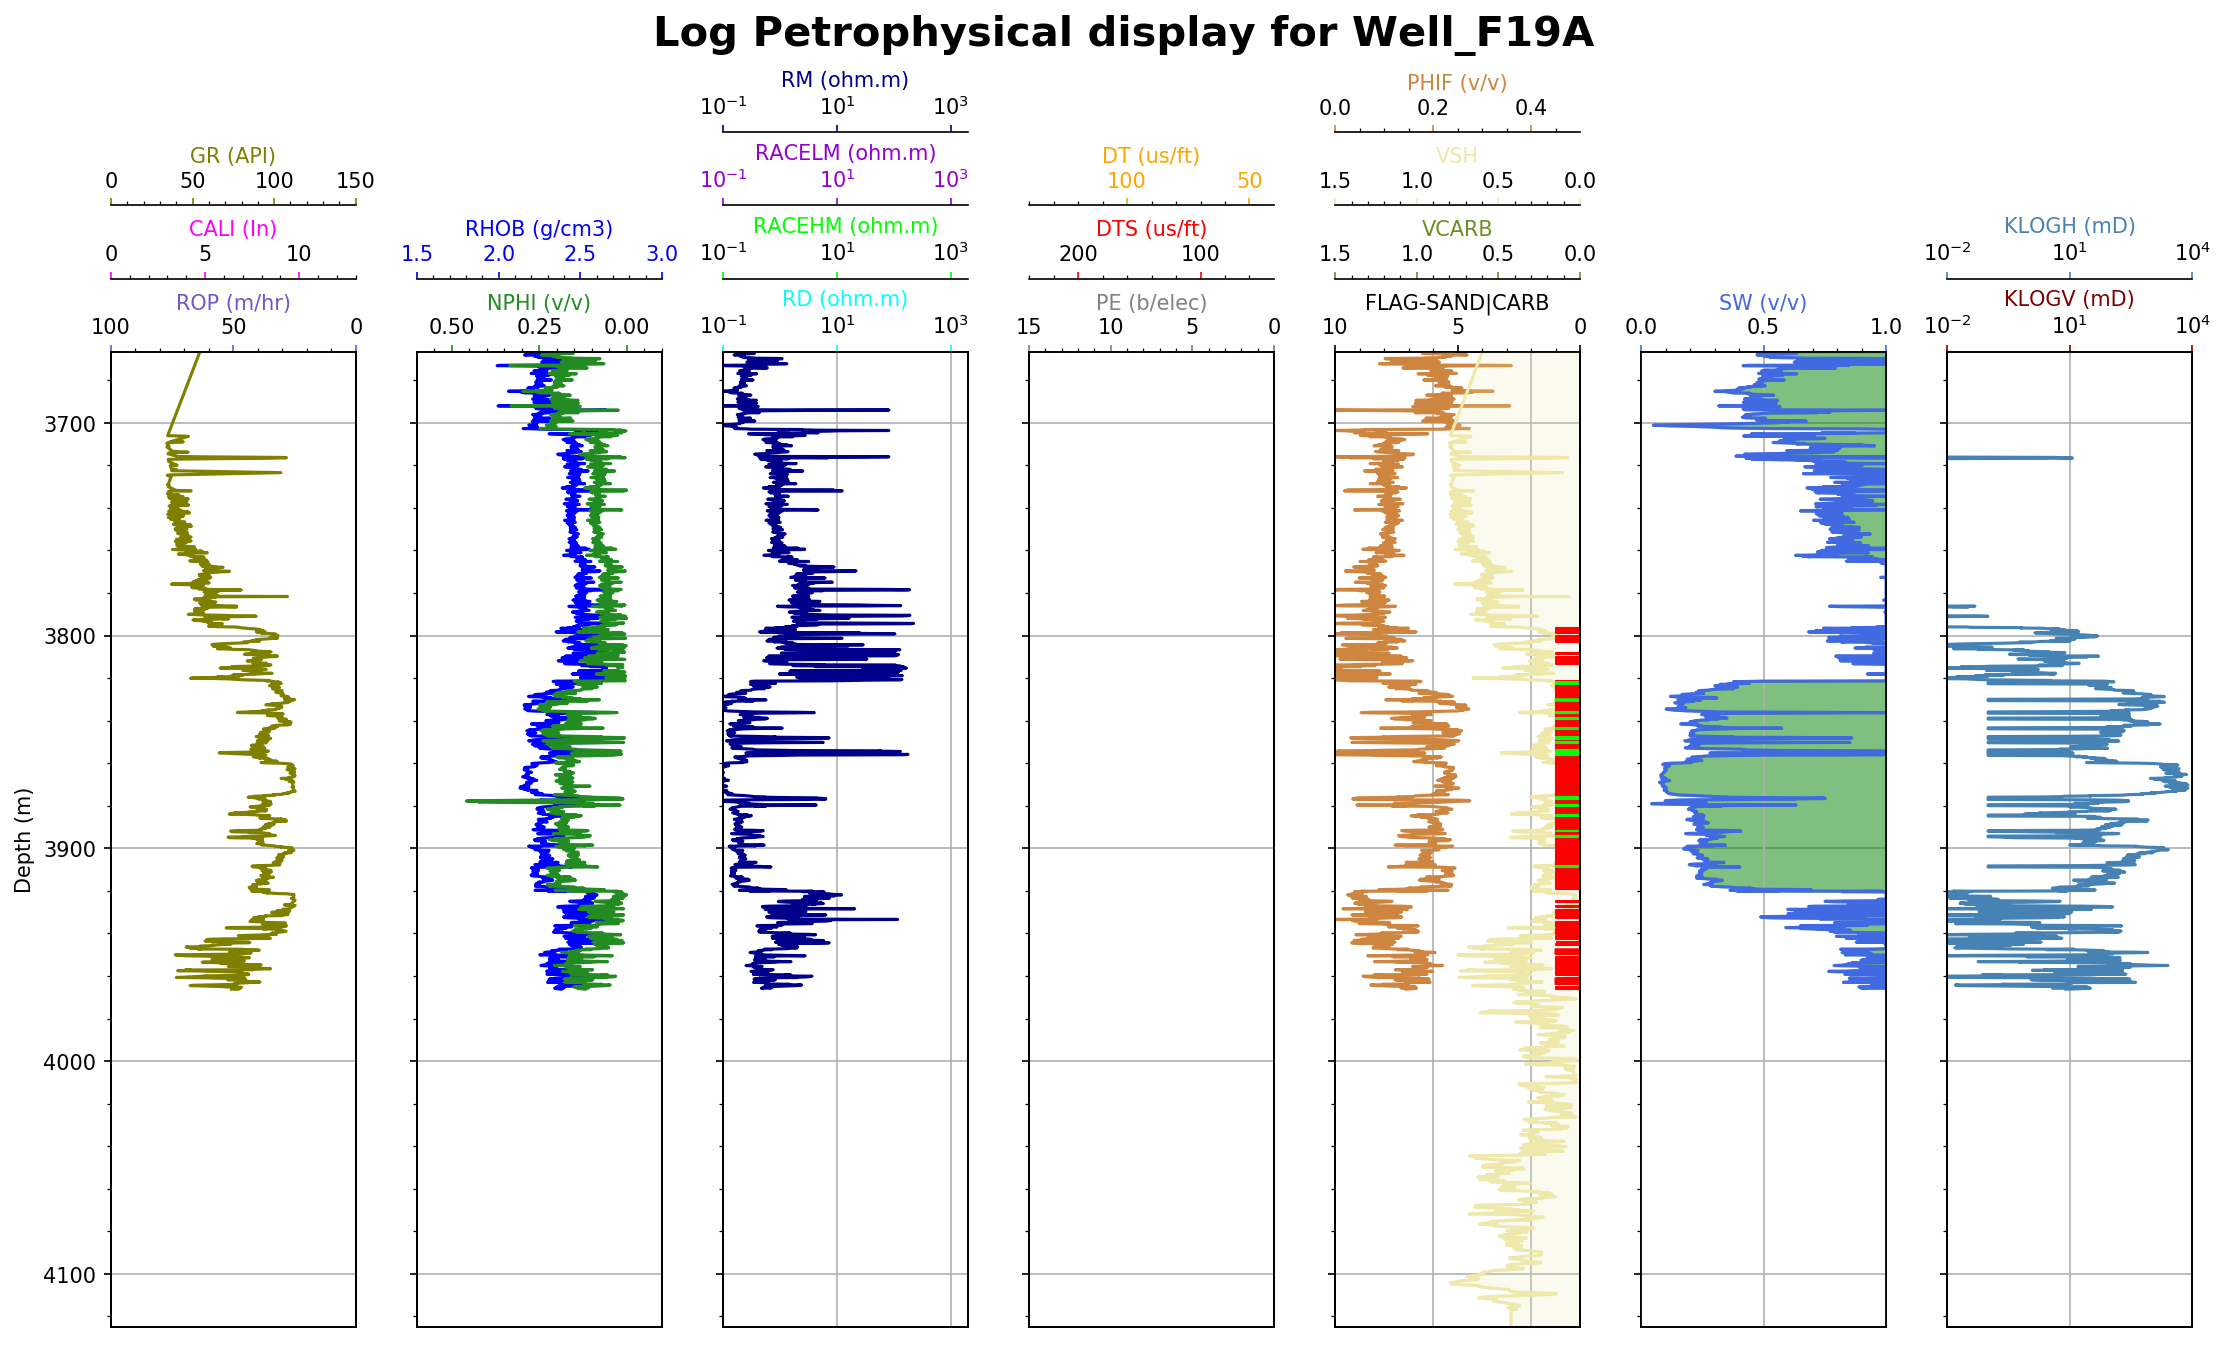

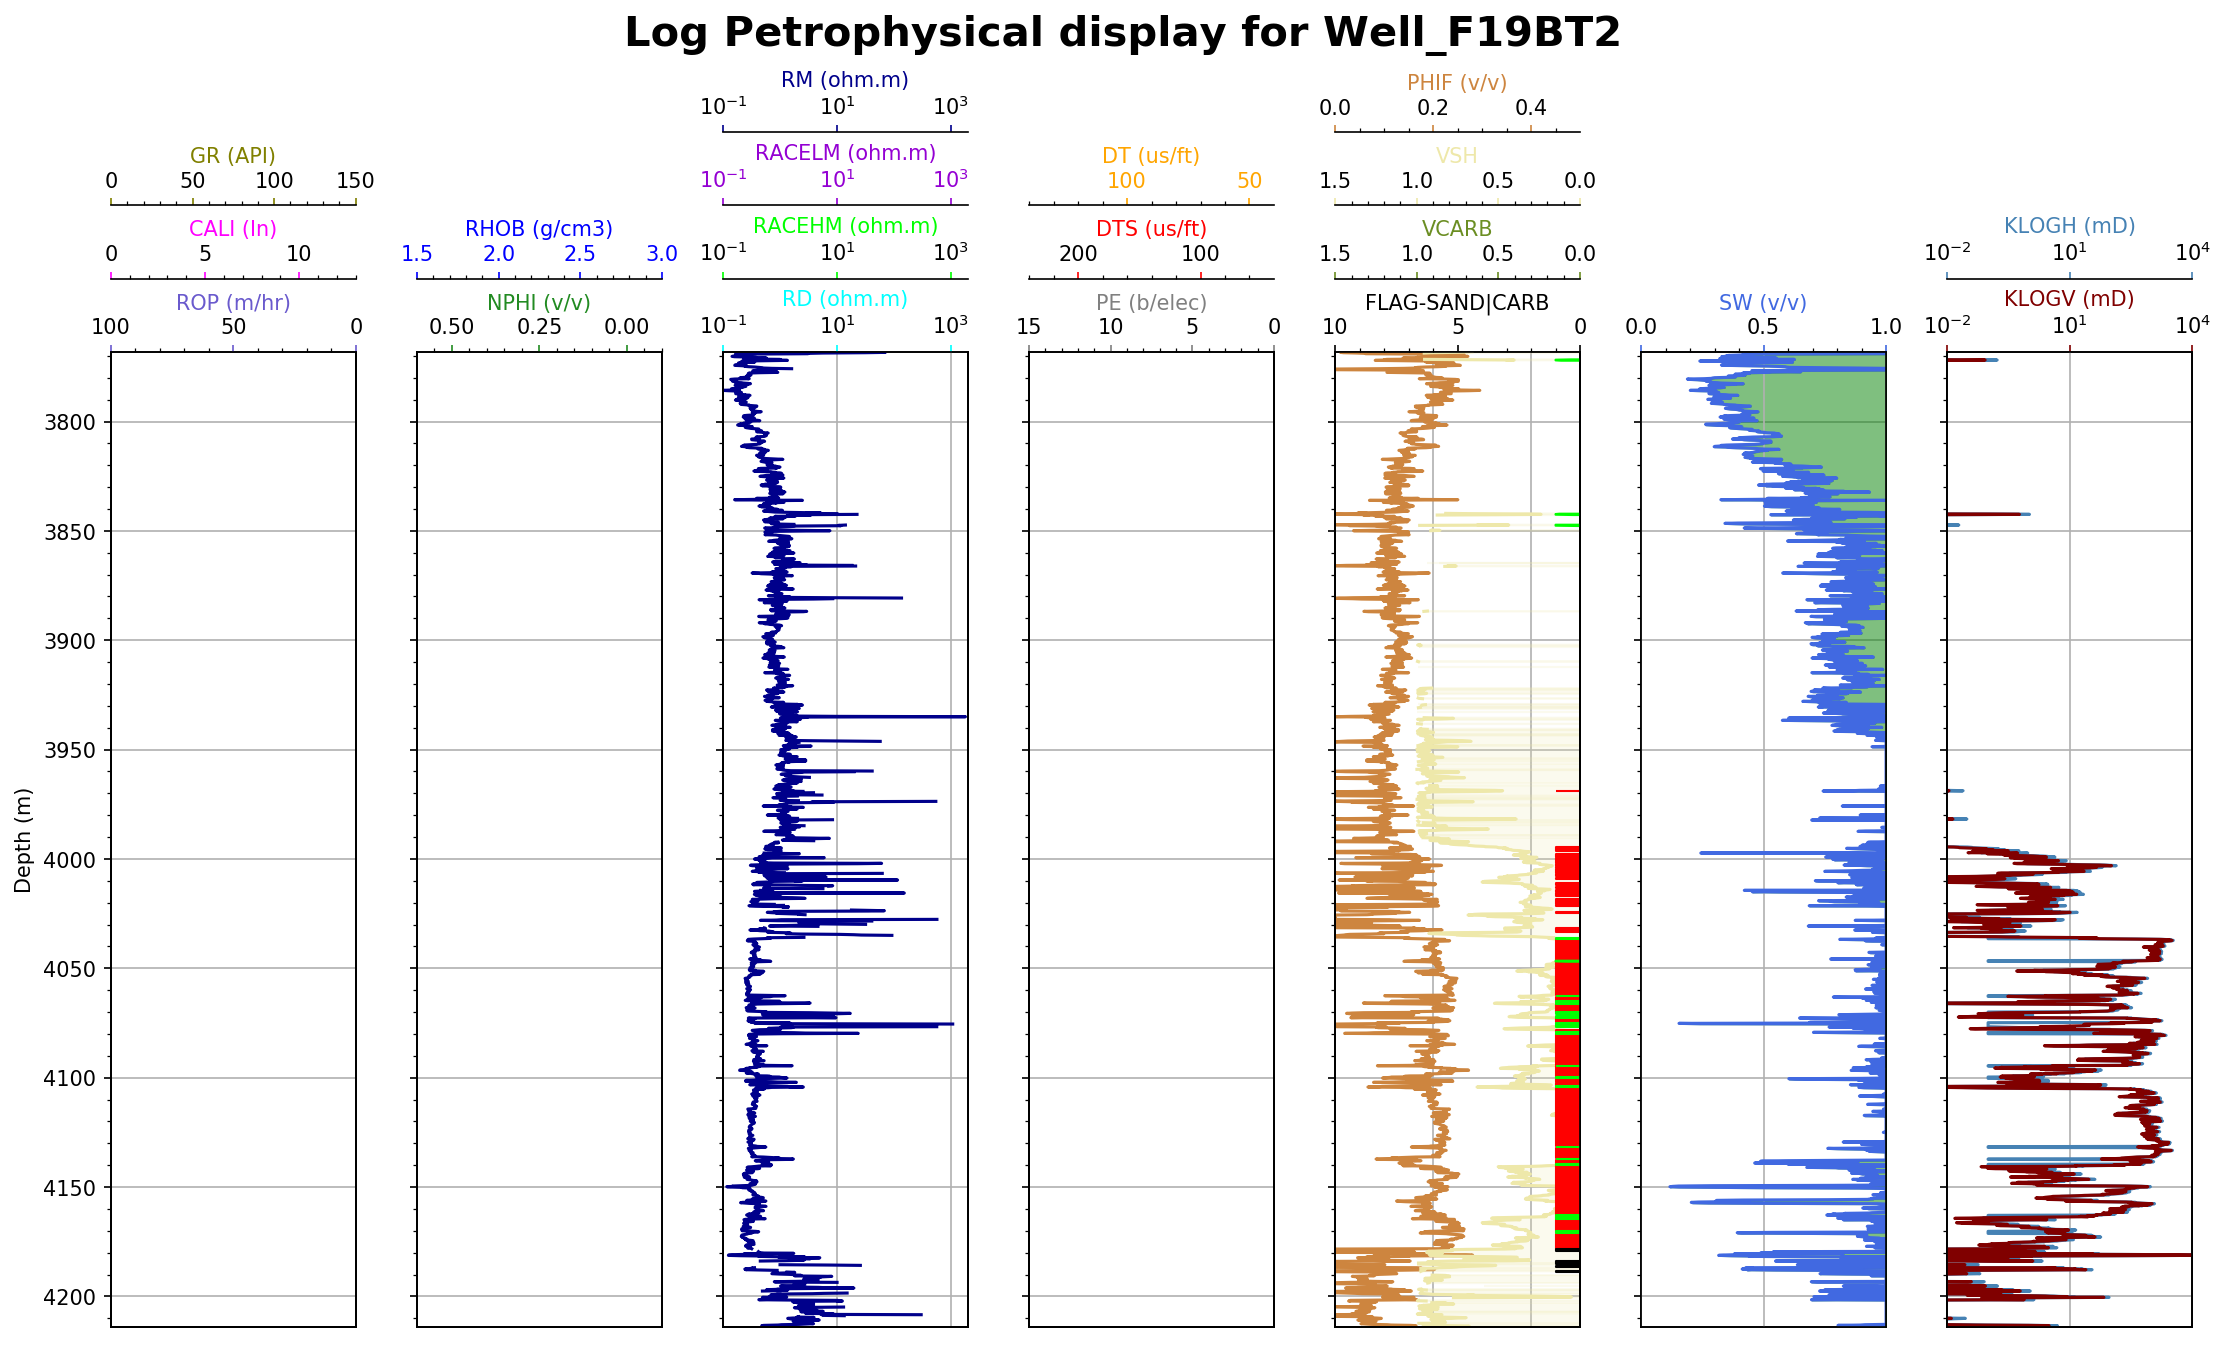

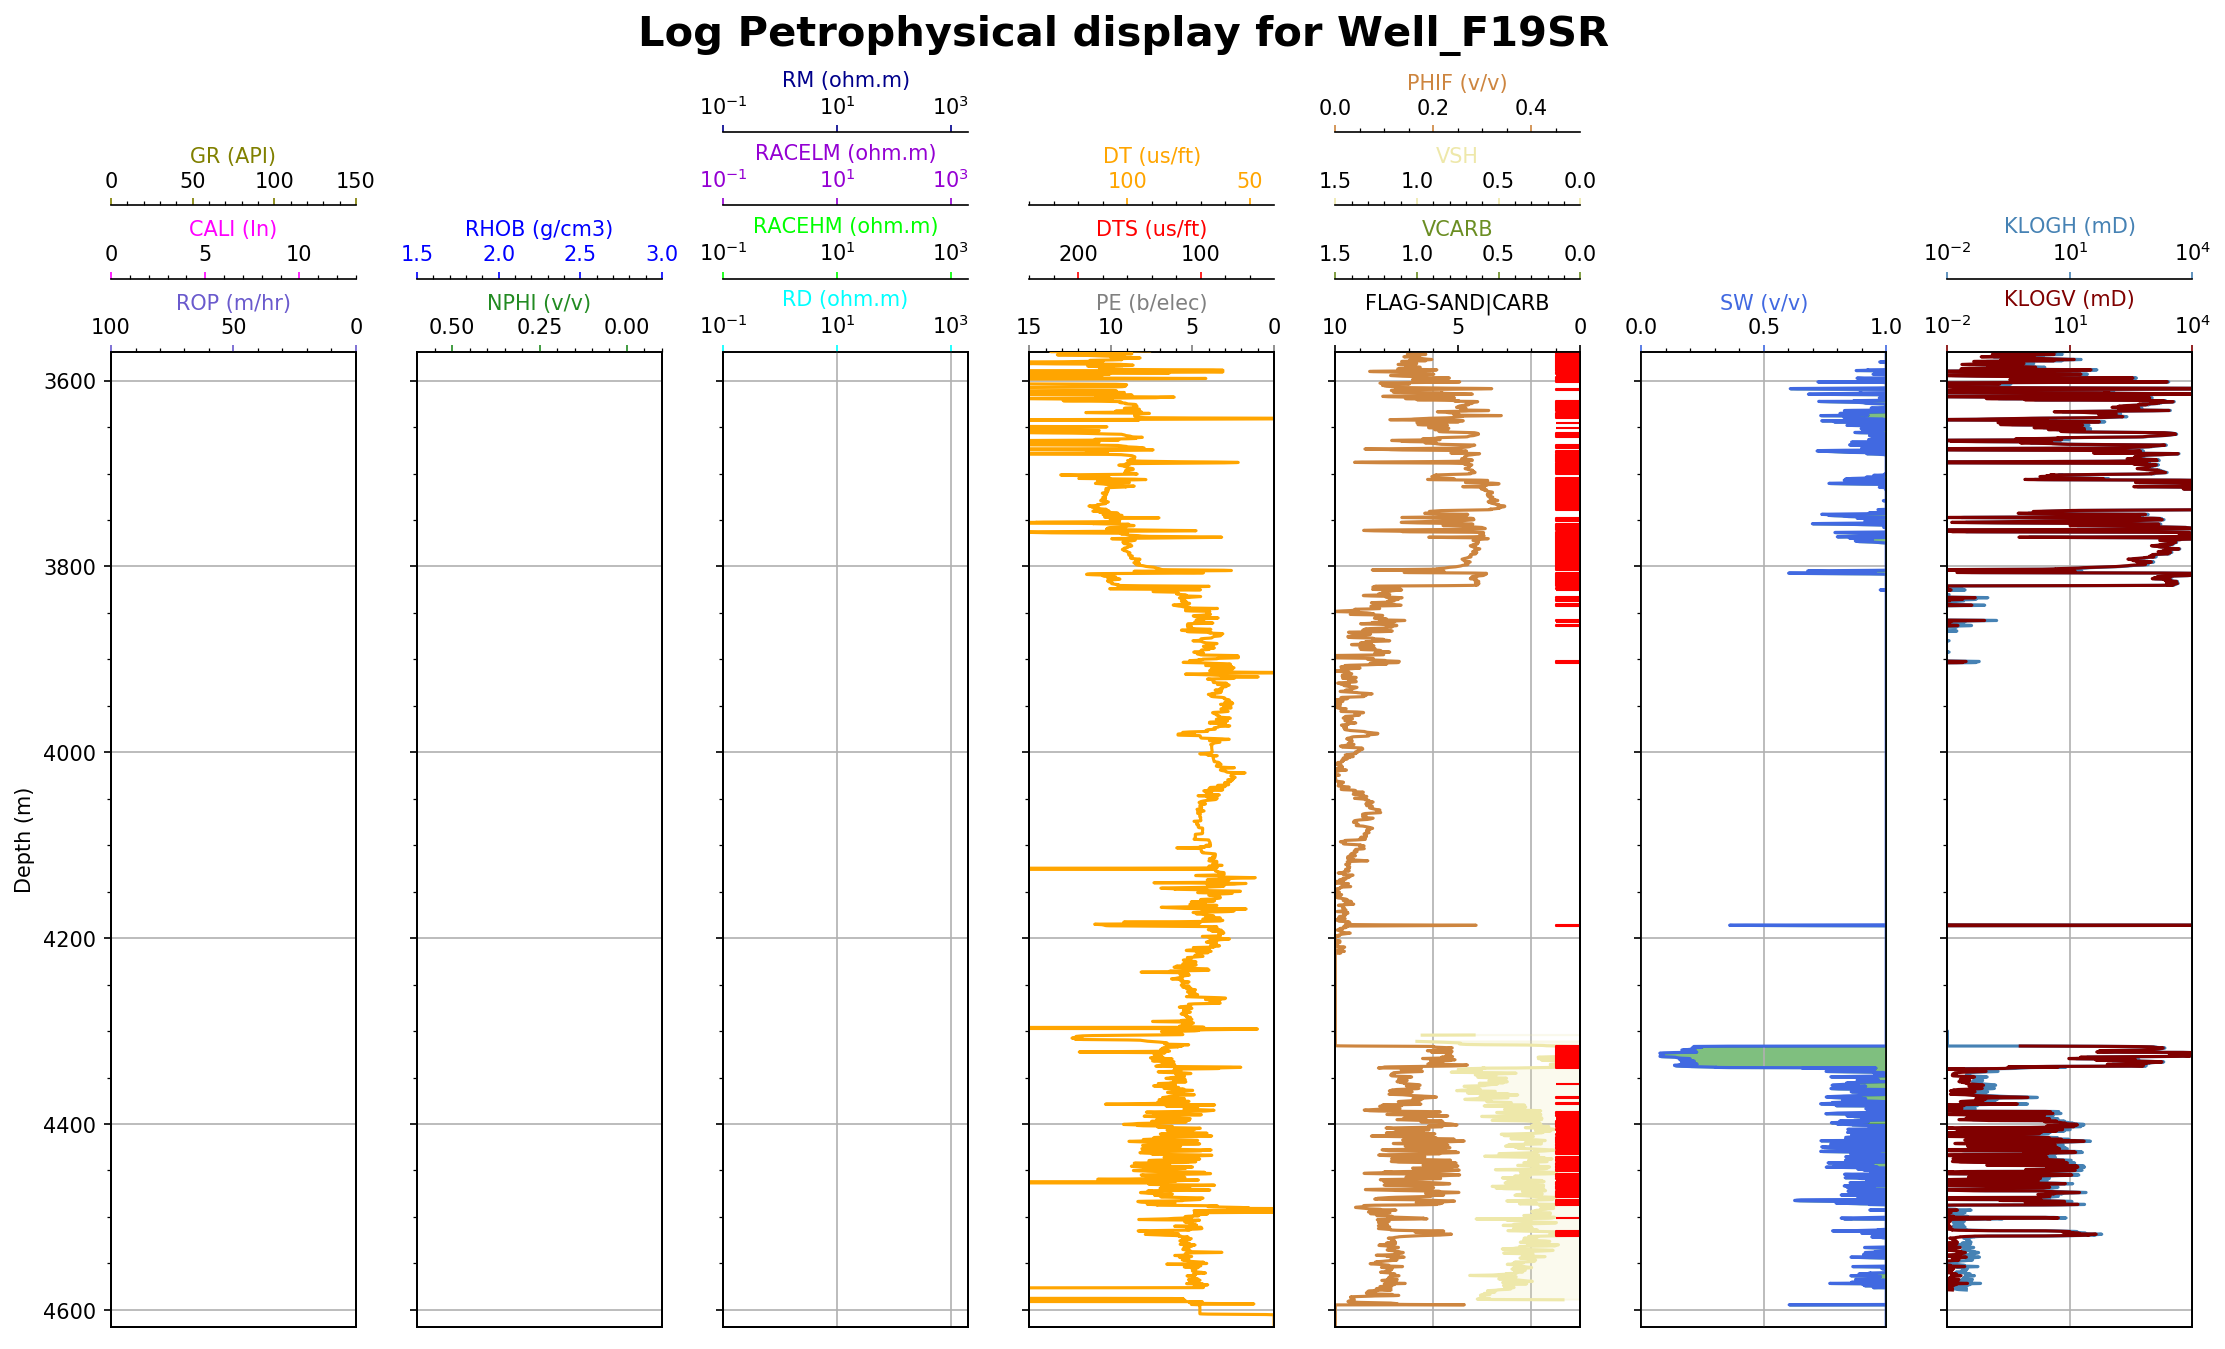

In [10]:
# generate plots for first three wells

for well in n_wells[:3]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

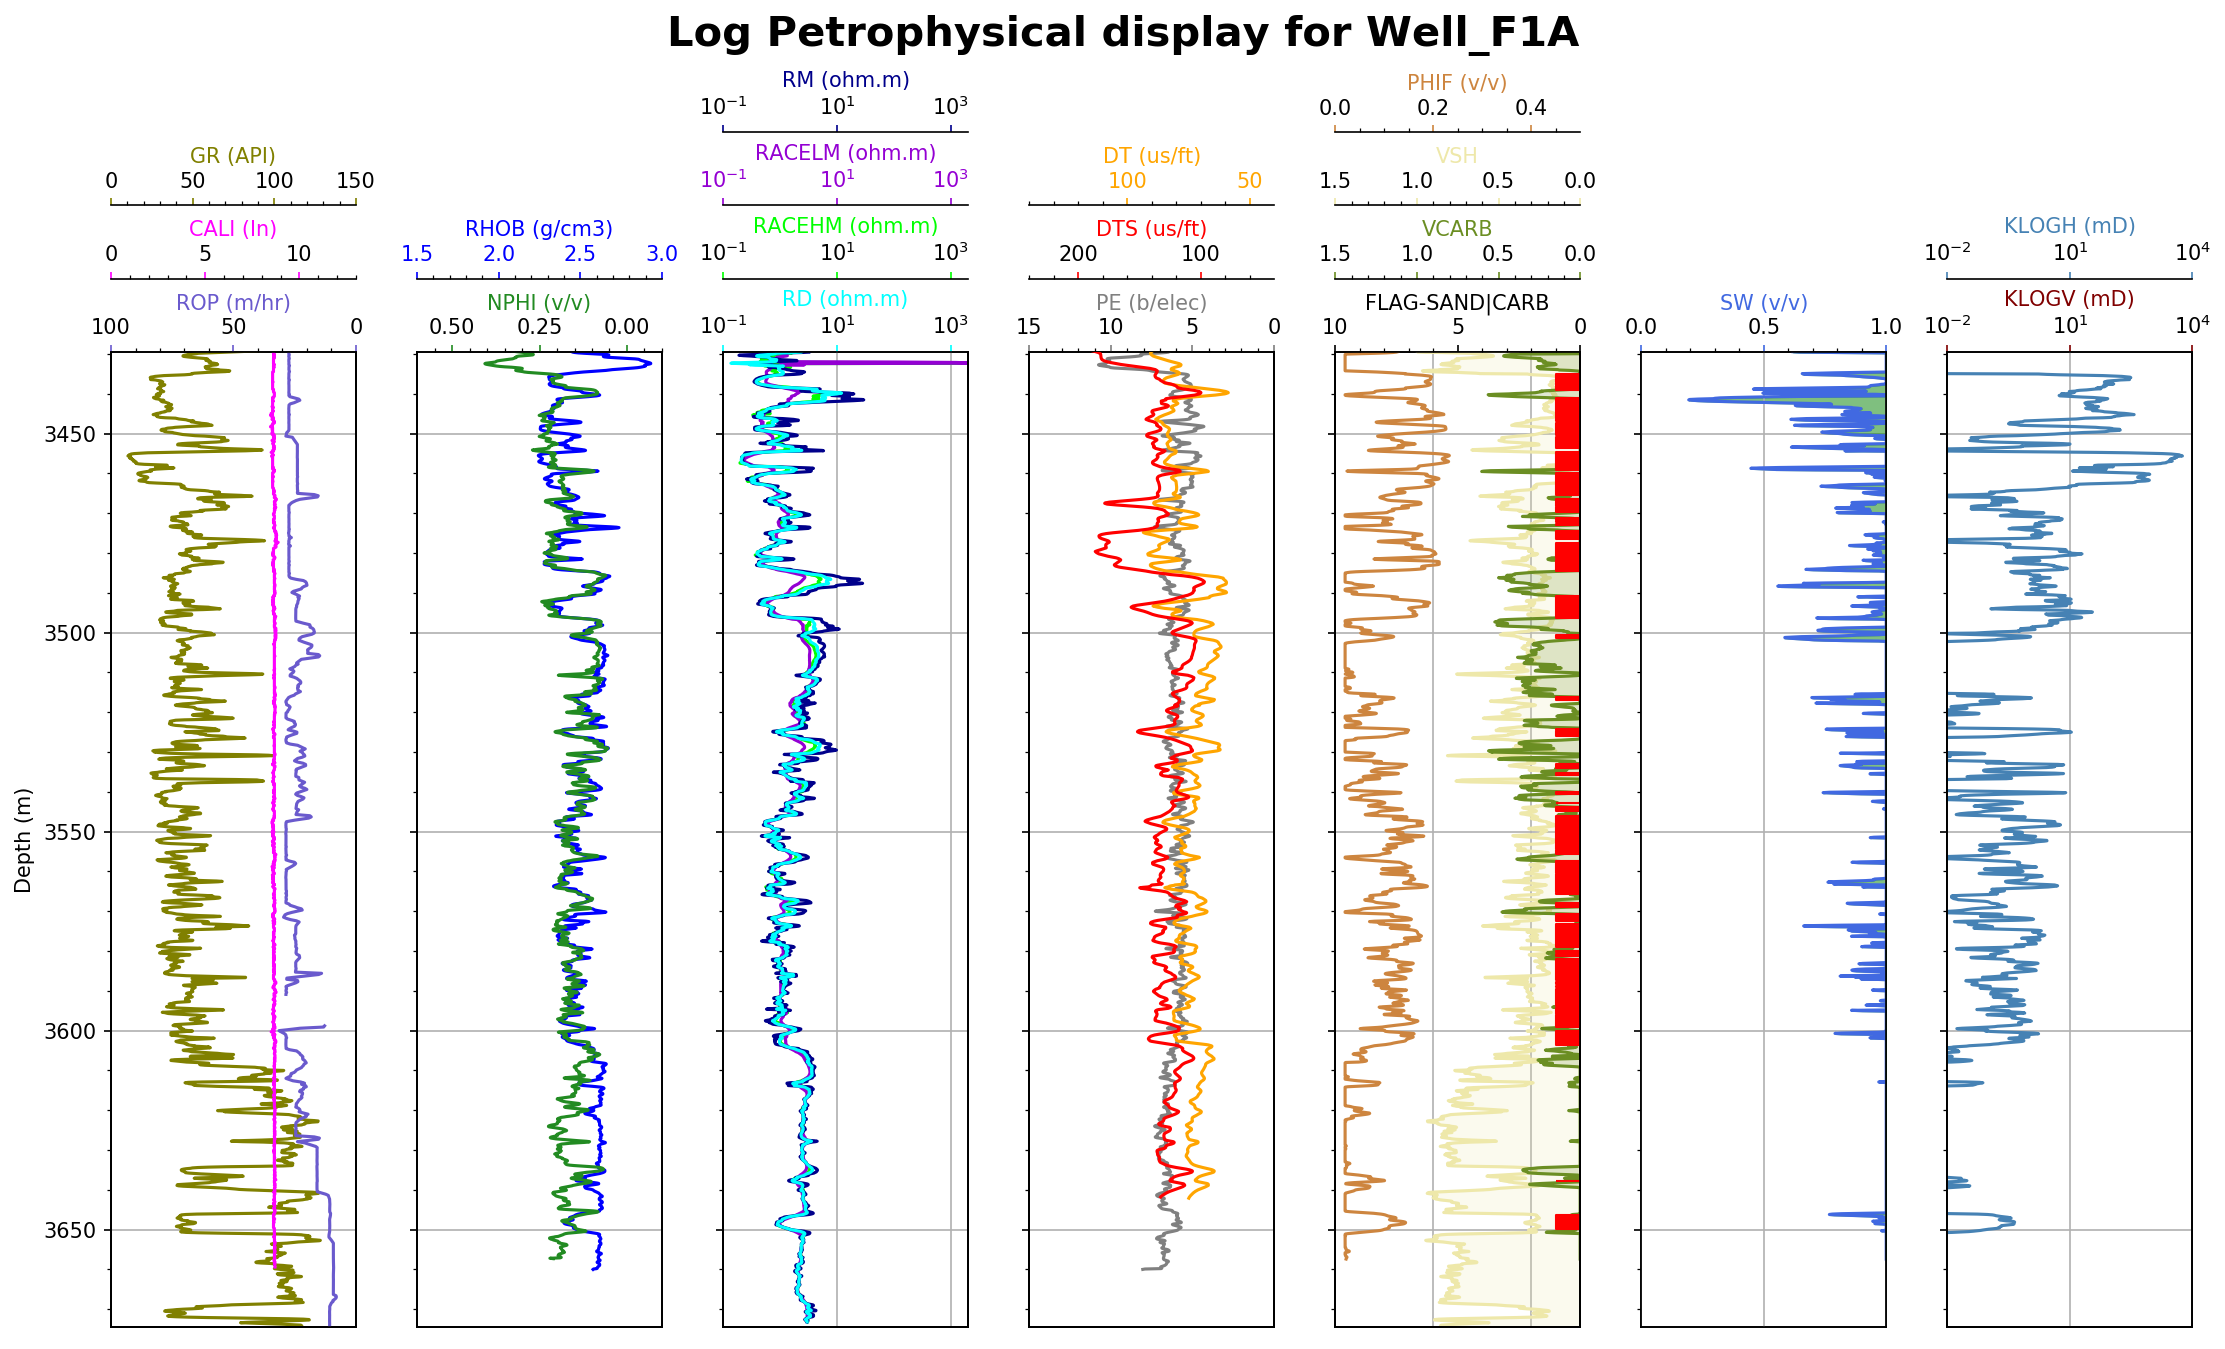

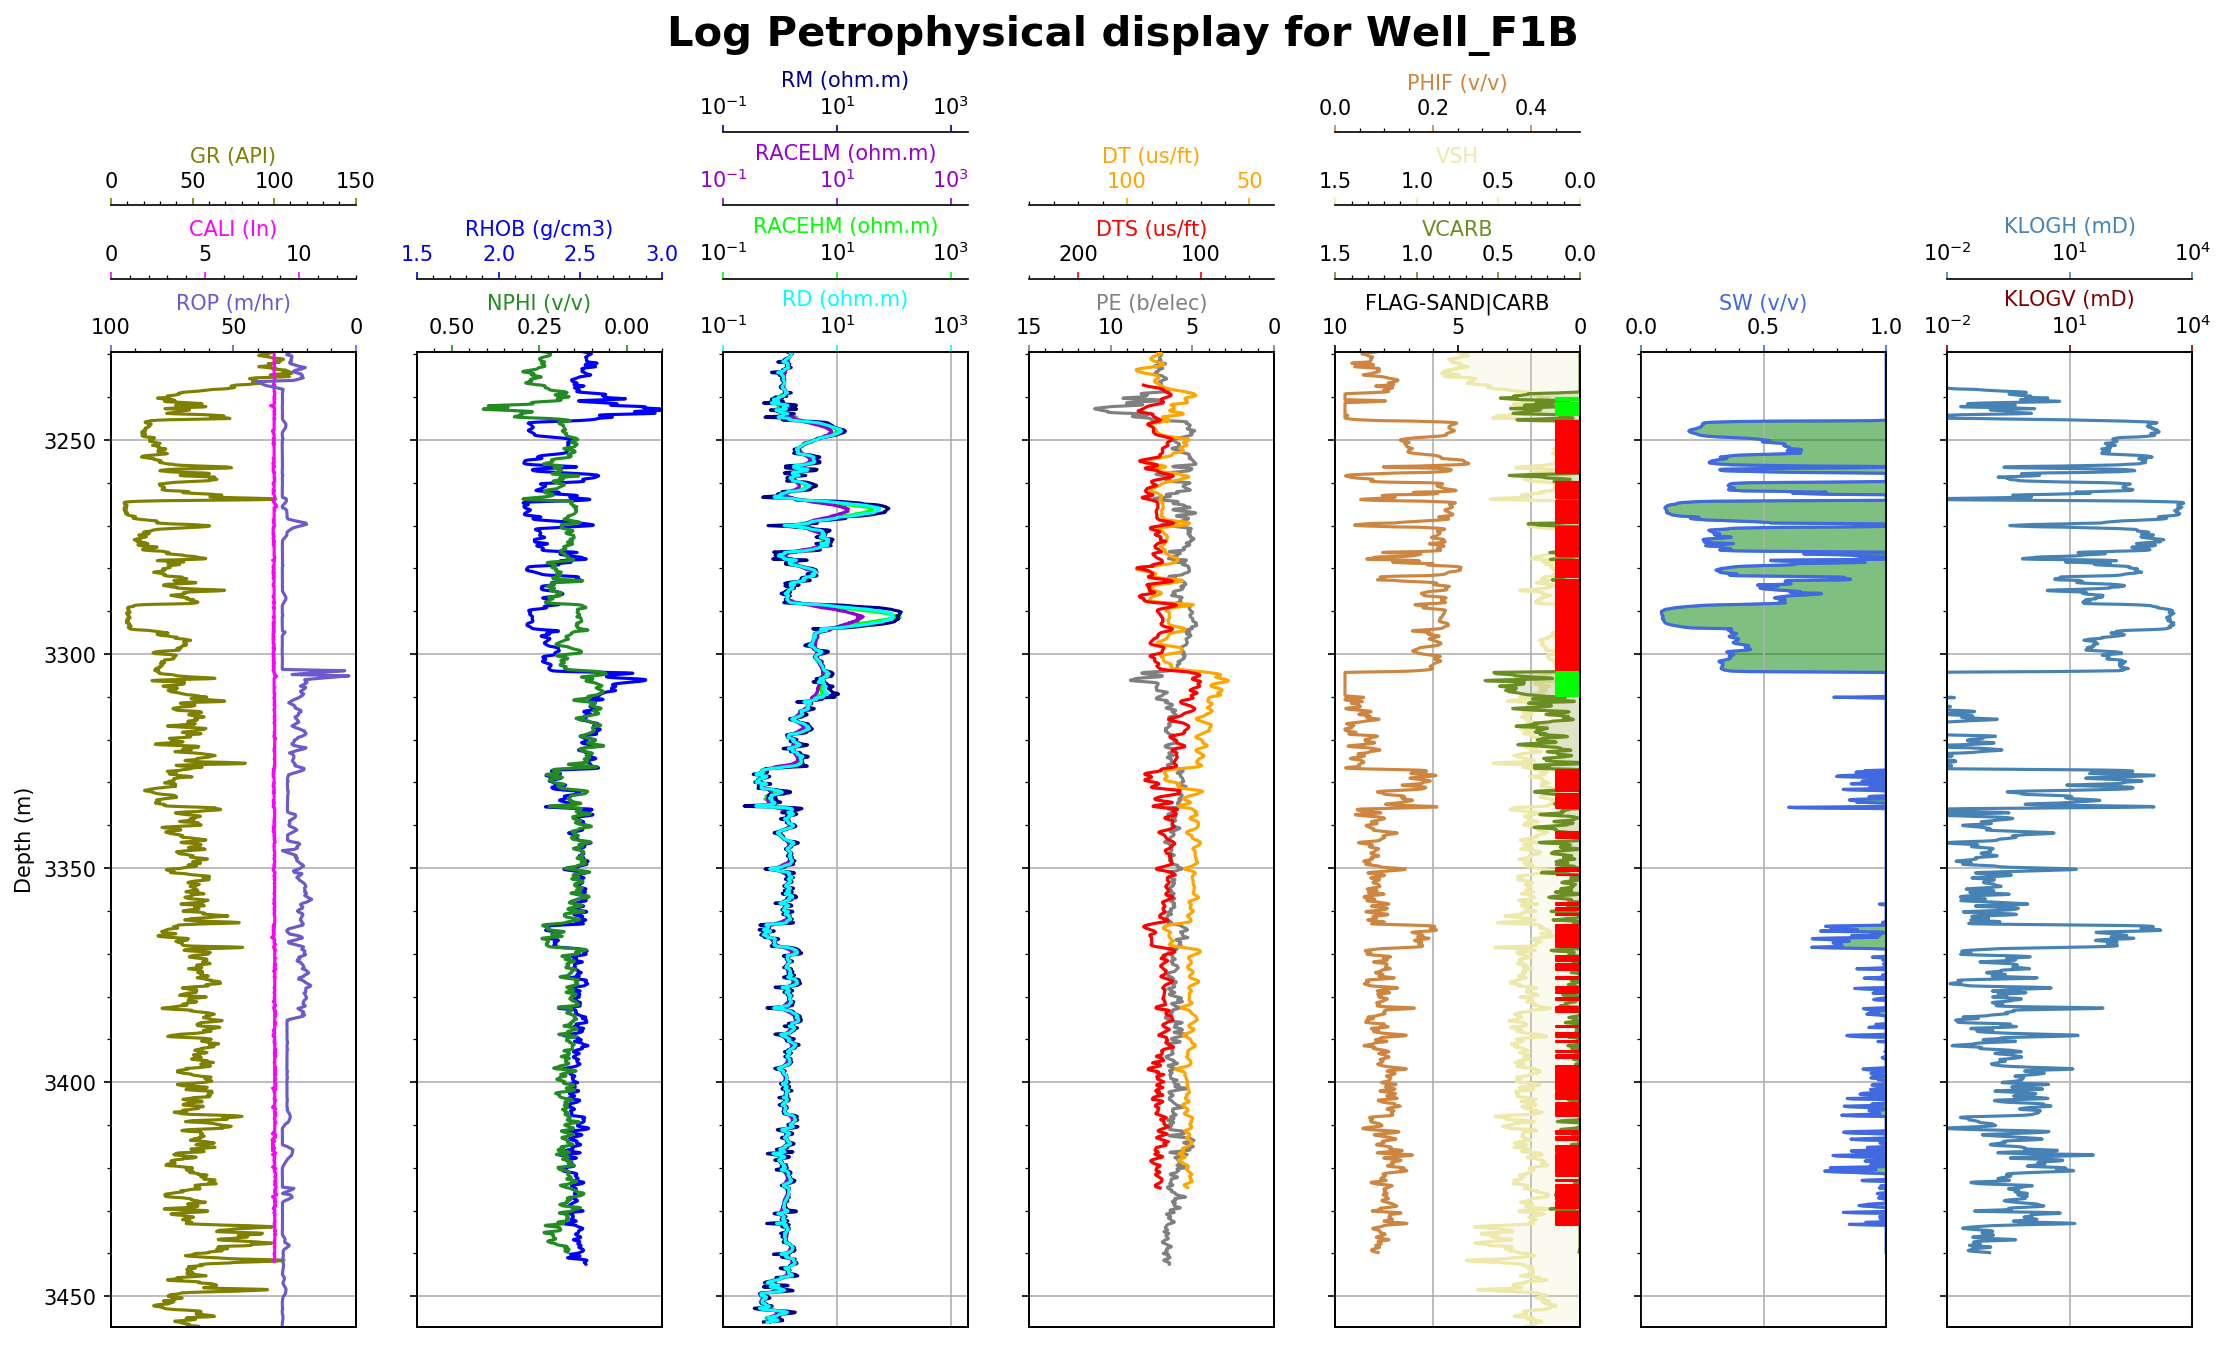

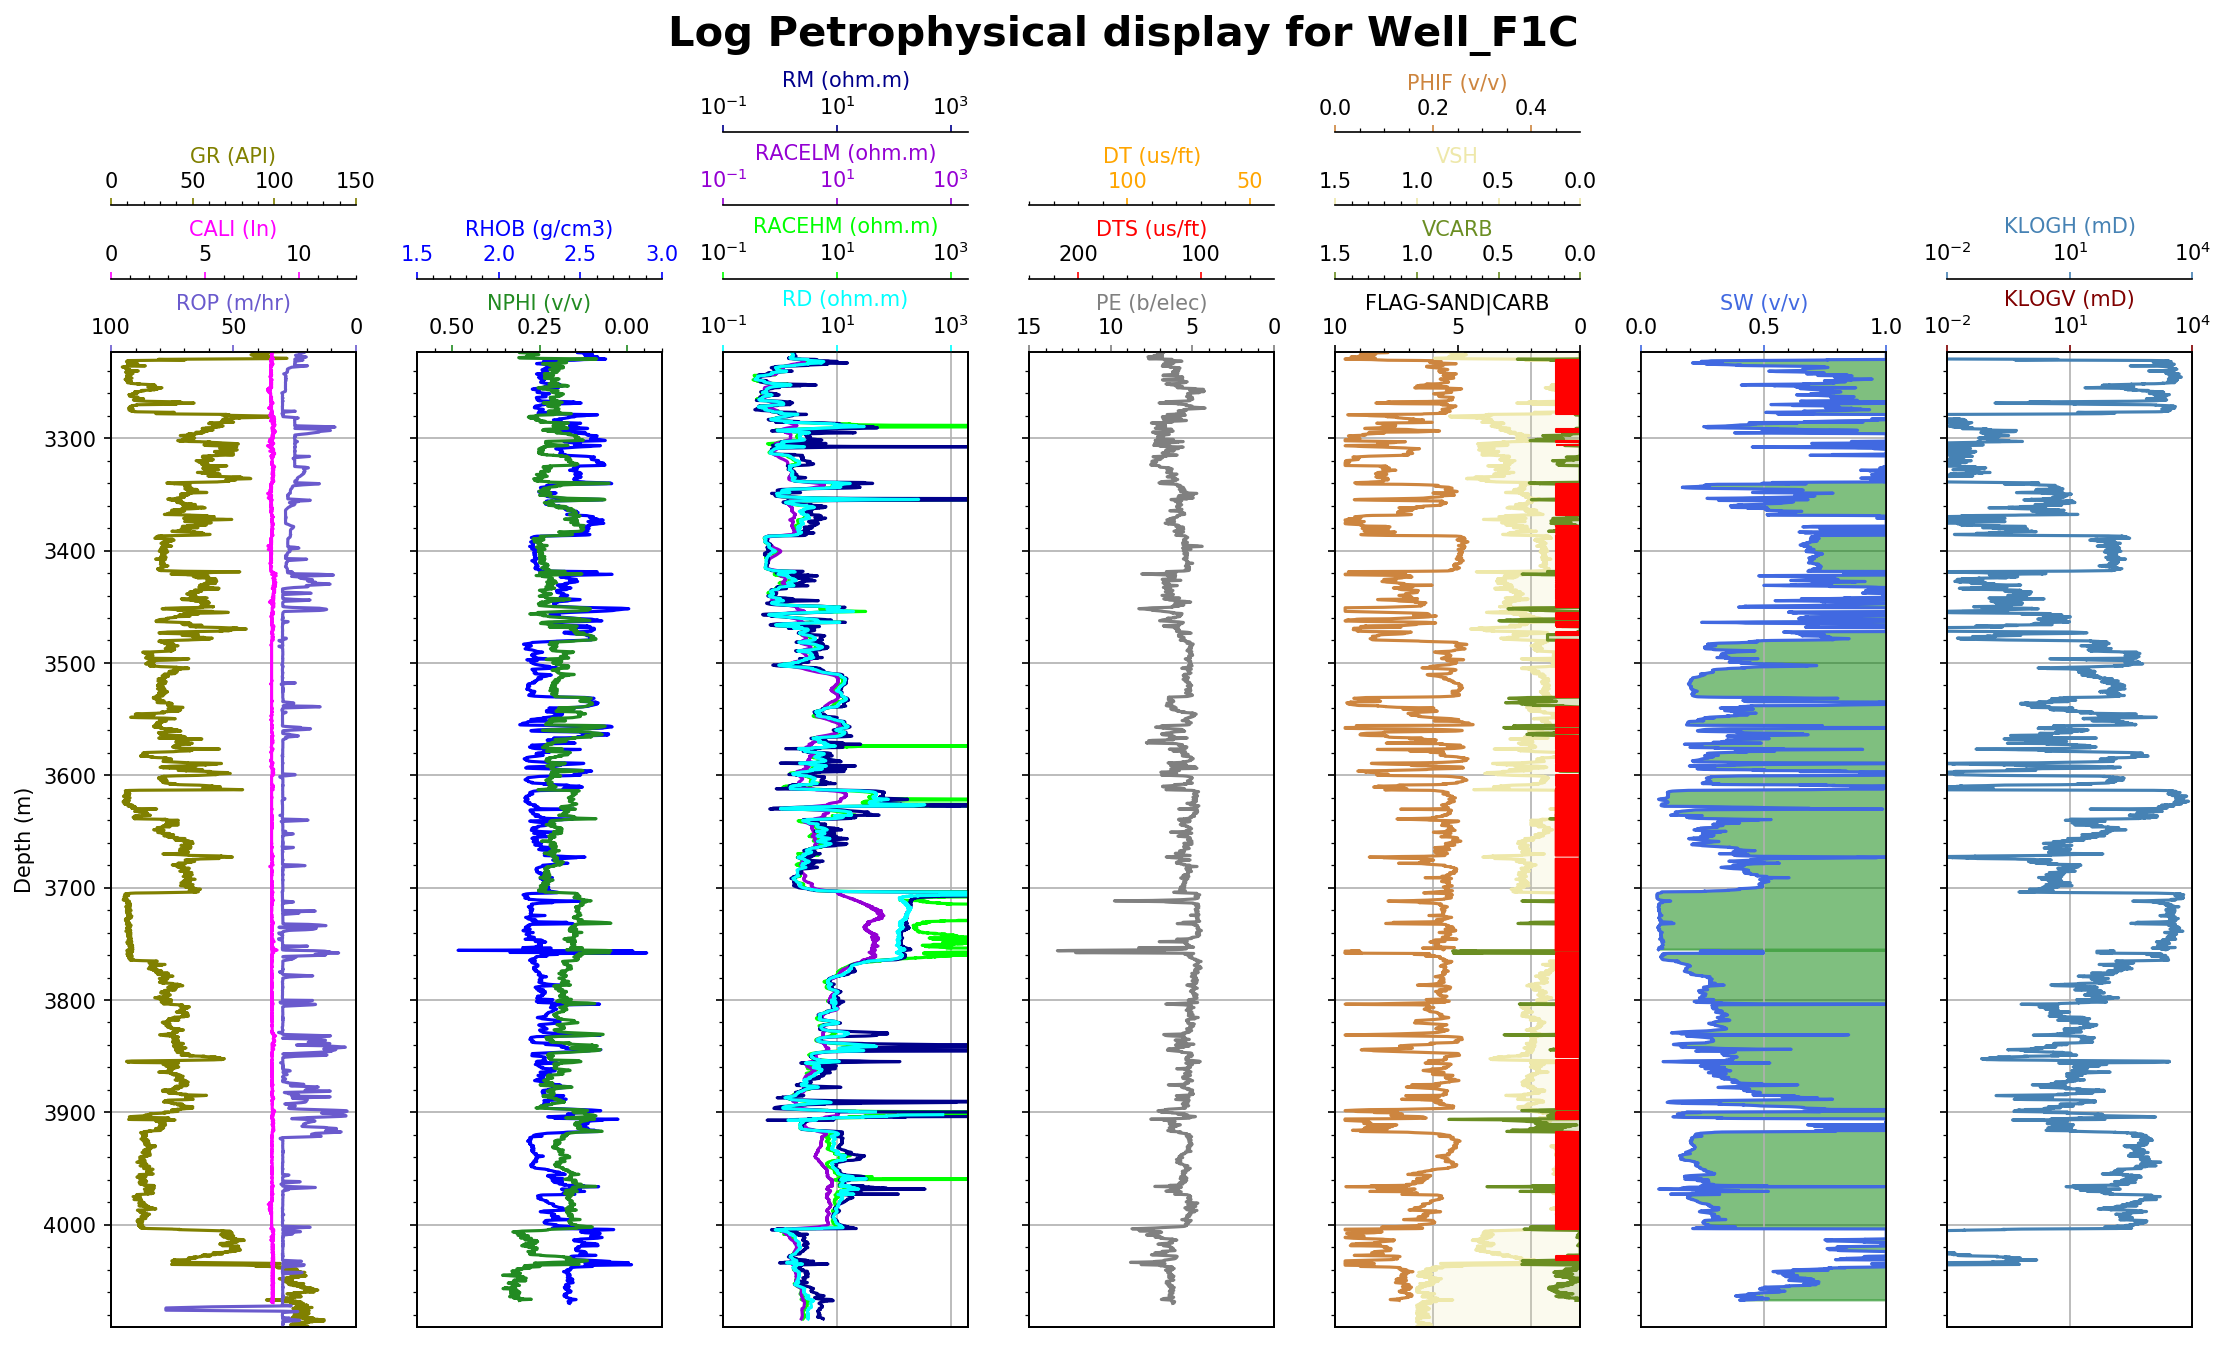

In [11]:
# generate plots for next three wells

for well in n_wells[3:6]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

In [ ]:
# generate plots for next three wells

for well in n_wells[6:9]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

In [ ]:
# generate plots for next three wells

for well in n_wells[9:12]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

In [ ]:
# generate plots for next three wells

for well in n_wells[12:15]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

In [ ]:
# generate plots for next three wells

for well in n_wells[15:18]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

In [ ]:
# generate plots for next three wells

for well in n_wells[18:]:
    well_name=data_final[data_final['WELL_NAME'] == '%s' % well]
    well_log_plot (well_name,depths=['TOP','BOTTOM'])

The combined well data are exported to CSV to be used prediction of VShale, DT, PHI, SW, PERM